# Creating MIRISim input skycubes for NGC7027

In [1]:
# load python modules
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.constants import c
from astropy.utils.data import get_pkg_data_filename
import scipy.interpolate as scp_interpolate
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# specify directory path
dataDir = "/Users/ioannisa/Desktop/python/miri_devel/notebooks/ISOSWS_PlanetaryNebulae/PNe_data/"

In [3]:
# give auxilliary data on MRS spectral bands
MRS_bands = {
    '1A':[4.83,5.82],
    '1B':[5.62,6.73],
    '1C':[6.46,7.76],
    '2A':[7.44,8.90],
    '2B':[8.61,10.28],
    '2C':[9.94,11.87],
    '3A':[11.47,13.67],
    '3B':[13.25,15.80],
    '3C':[15.30,18.24],
    '4A':[17.54,21.10],
    '4B':[20.44,24.72],
    '4C':[23.84,28.82]} # microns

<IPython.core.display.Javascript object>


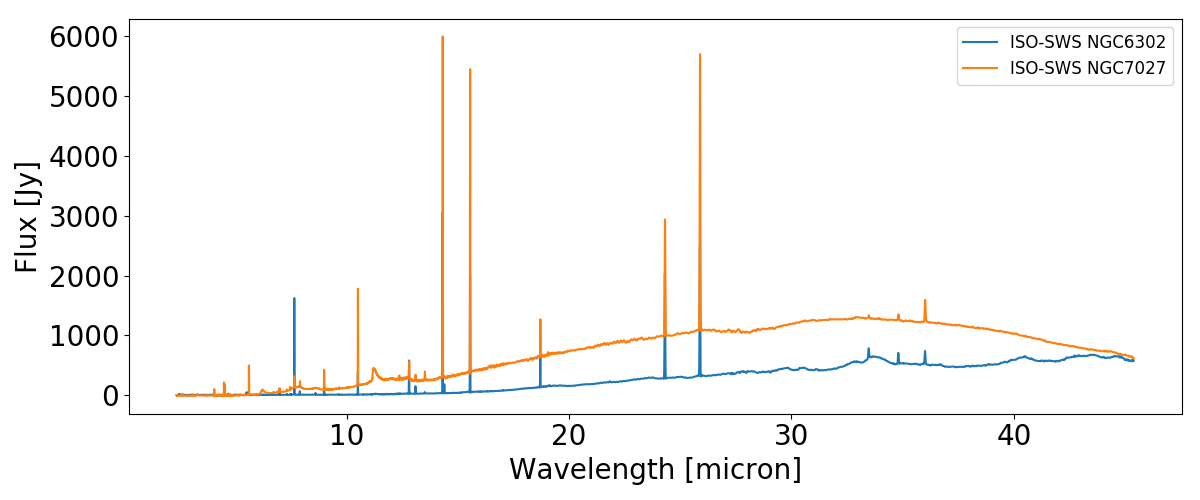

In [4]:
# Accessing wavelength (micron), flux density (Jansky) in planetary nebulae spectra of ISO-SWS / Highly Processed Data Products (HPDP) by Greg Sloan et al.
spec_hdulist1 = fits.open(dataDir + "09400716_sws.fit") # ISO-SWS NGC6302
spec_hdulist2 = fits.open(dataDir + "55800537_sws.fit") # ISO-SWS NGC7027

plt.figure(figsize=(12,5))
plt.plot(spec_hdulist1[0].data[:,0], spec_hdulist1[0].data[:,1],label="ISO-SWS NGC6302")
plt.plot(spec_hdulist2[0].data[:,0], spec_hdulist2[0].data[:,1],label="ISO-SWS NGC7027")
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Flux [Jy]',fontsize=20)
plt.legend(loc='upper right',fontsize=12)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

### Plot FoV image of NGC 7027

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


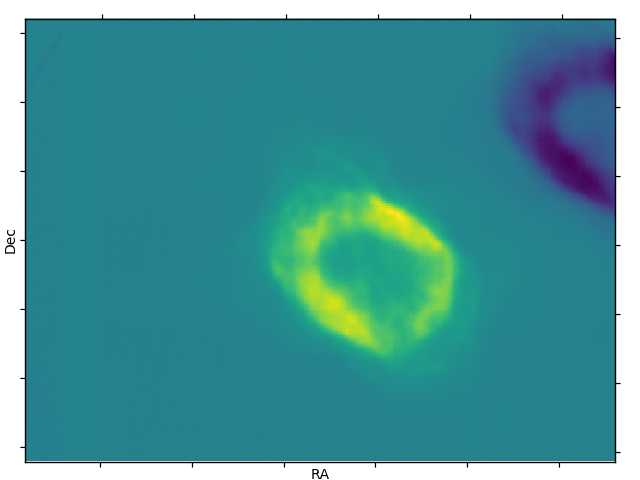

In [5]:
img_filename = dataDir + "N20080702S0123.fits"
w = WCS(img_filename)
img_hdulist = fits.open(img_filename)
wcs = WCS(img_hdulist[0].header)

NAXIS1 = img_hdulist[1].data.shape[2]
NAXIS2 = img_hdulist[1].data.shape[3]
x = np.arange(NAXIS2)
y = np.arange(NAXIS1)
X, Y = np.meshgrid(x, y)
ra, dec = w.wcs_pix2world(X,Y, 0)

# x,y = 100,100
# print 'RA/DEC of pixel (x,y)=({},{}): {}'.format(x,y,w.wcs_pix2world(x,y, 1))

fig = plt.figure()
fig.add_subplot(111, projection=wcs)
plt.imshow(img_hdulist[1].data[0,0,:,:], origin='lower', cmap=plt.cm.viridis)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.tight_layout()

<IPython.core.display.Javascript object>


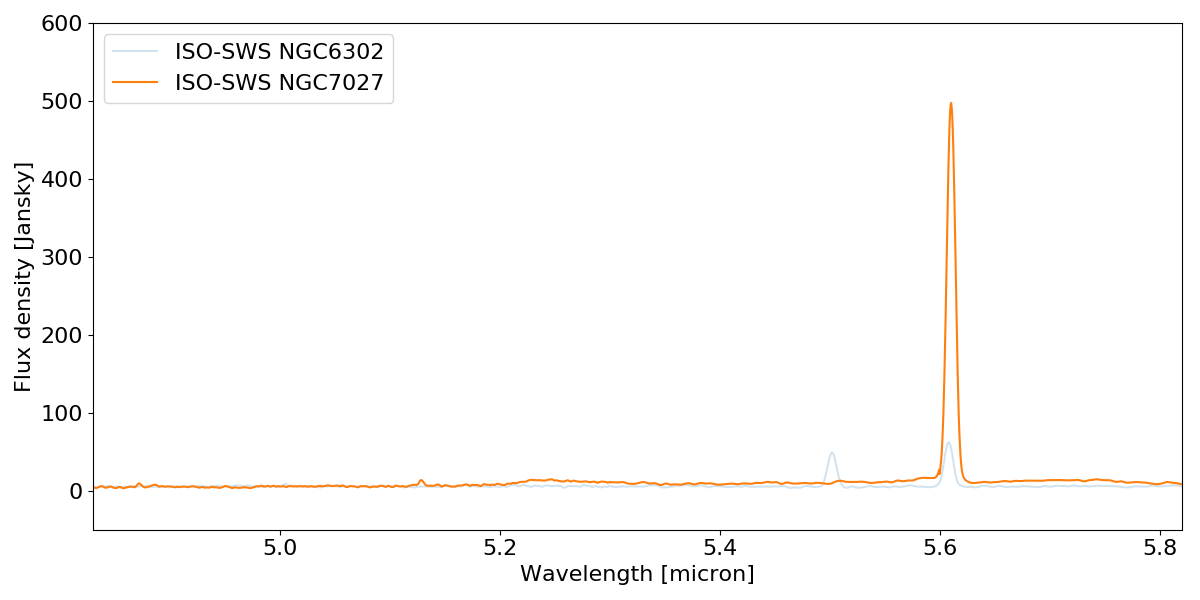

In [6]:
# load spectral energy distribution of NGC7027
spec_filename = dataDir + "55800537_sws.fit"
spec_hdulist = fits.open(spec_filename)
wavl = spec_hdulist[0].data[:,0]
spec = spec_hdulist[0].data[:,1]

# use reference flux at 3 micron to derive correction for NGC7027 spectrum below 6micron
ref_wvl   = 3*10**-6 # m
ref_value = 5 * 10** -17 # Watt cm-2 micron-1

ref_value *= 10**4            # Watt m-2 micron-1
ref_value *= (ref_wvl**2 / c.value) # Watt m-2 Hz -1
ref_value *= 10**26           # Jansky 

spec[wavl<5.6] += (ref_value-spec[wavl<5.6].min())

plt.figure(figsize=(12,6))
sel = (wavl>=MRS_bands['1A'][0]) & (wavl<=MRS_bands['1A'][1])
plt.plot(spec_hdulist1[0].data[:,0], spec_hdulist1[0].data[:,1],label="ISO-SWS NGC6302",alpha=0.2)
plt.plot(wavl[sel],spec[sel],label="ISO-SWS NGC7027")
plt.xlim(wavl[sel].min(),wavl[sel].max())
plt.ylim(-50,600)
plt.xlabel('Wavelength [micron]',fontsize=16)
plt.ylabel('Flux density [Jansky]',fontsize=16)
plt.legend(loc='upper left',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()

### Build MIRISim input skycube from spatial and spectral information of NGC7027

In [ ]:
# UNCOMMENT TO BUILD MIRISIM CUBES
# spatial distribution NGC7027
img_hdulist = fits.open(img_filename)
pixel_scale = img_hdulist[0].header['PIXELSIZ']  # arcsec/pix
NGC7027_img = img_hdulist[1].data[0,0,:,:]
#> normalise the image
image_total = np.sum(np.sum(NGC7027_img, axis=0), axis=0)
norm_image = NGC7027_img / image_total
image_dim = norm_image.shape

# create the datacubes
for band in ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']:
    print 'Band {}'.format(band)
    # give output filename
    out_filename = "mirisim_input_cubes/NGC7027_mirisim_input_cube_band{}.fits".format(band)
    # spectral distribution, [microns] and [Jy]
    sel_wvl = (wavl>=MRS_bands[band][0]) & (wavl<=MRS_bands[band][1])
    wave_scale  = wavl[sel_wvl][1]-wavl[sel_wvl][0]
    interp_wavl = np.arange(wavl[sel_wvl][0]+wave_scale,wavl[sel_wvl][-1]-wave_scale,wave_scale)
    interp_spec = scp_interpolate.interp1d(wavl[sel_wvl],spec[sel_wvl])(interp_wavl)
    wave_length = len(interp_wavl)
    
    # create the datacube
    datacube = np.zeros([wave_length,image_dim[0],image_dim[1]])
    for n in range(wave_length):
        frame = ((interp_spec[n] * norm_image) * 1.e6) /pixel_scale**2 # convert Jansky to microJy per arcsec^2
        datacube[n,:,:] = frame
    
    prihdr = fits.Header()
    prihdr['CRVAL1'] = 0
    prihdr['CRPIX1'] = img_hdulist[0].header["CRPIX1"]
    prihdr['CDELT1'] = img_hdulist[0].header["PIXELSIZ"]
    prihdr['CTYPE1'] = 'RA---TAN'
    prihdr['CUNIT1'] = 'arcsecond'
    prihdr['CRVAL2'] = 0
    prihdr['CRPIX2'] = img_hdulist[0].header["CRPIX2"]
    prihdr['CDELT2'] = img_hdulist[0].header["PIXELSIZ"]
    prihdr['CTYPE2'] = 'DEC--TAN'
    prihdr['CUNIT2'] = 'arcsecond'
    prihdr['CRVAL3'] = interp_wavl[0]
    prihdr['CRPIX3'] = 0
    prihdr['CDELT3'] = wave_scale    
    prihdr['CTYPE3'] = 'WAVE'
    prihdr['CUNIT3'] = 'micron'
    prihdr['UNITS'] = 'uJy arcsec-2'
    
    # save fits
    out_hdu = fits.PrimaryHDU(datacube,header=prihdr)
    hdulist = fits.HDUList([out_hdu])
    hdulist.writeto(out_filename,overwrite=True)
    hdulist.close()